In [4]:
!pip install xgboost
!pip install shap
!pip install lime

In [5]:
import pandas as pd
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import shap
import lime
import lime.lime_tabular

In [6]:
df = pd.read_csv('dataset/heloc.csv')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10459 entries, 0 to 10458
Data columns (total 24 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   RiskPerformance                     10459 non-null  object
 1   ExternalRiskEstimate                10459 non-null  int64 
 2   MSinceOldestTradeOpen               10459 non-null  int64 
 3   MSinceMostRecentTradeOpen           10459 non-null  int64 
 4   AverageMInFile                      10459 non-null  int64 
 5   NumSatisfactoryTrades               10459 non-null  int64 
 6   NumTrades60Ever2DerogPubRec         10459 non-null  int64 
 7   NumTrades90Ever2DerogPubRec         10459 non-null  int64 
 8   PercentTradesNeverDelq              10459 non-null  int64 
 9   MSinceMostRecentDelq                10459 non-null  int64 
 10  MaxDelq2PublicRecLast12M            10459 non-null  int64 
 11  MaxDelqEver                         10459 non-null  in

In [8]:
# 특징과 라벨 분리 (헬로크 데이터에서 y값을 'RiskPerformance'로 가정)
X = df.drop(columns=['RiskPerformance'])  # 입력 변수
y = df['RiskPerformance'].apply(lambda x: 1 if x == 'Bad' else 0)  # 'Bad'를 1로, 'Good'을 0으로 변환

# 학습/테스트 데이터 분리
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost용 데이터 형식 변환
dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(x_test, y_test)

# 기본 하이퍼파라미터 설정
param = {'silent':True, 'objective':'binary:logistic', "eta":0.05, 'eval_metric': 'rmse',
         'monotone_constraints':"(1,1,1,1,-1,-1,1,0,0,-1,-1,-1,0,-1,0,1,1)"}

# Cross-validation으로 적절한 boosting round 찾기
bst_cv = xgb.cv(param, dtrain, 500, nfold=10, early_stopping_rounds=10)

# 모델 훈련
evals_result = {}
evallist  = [(dtrain, 'train'), (dtest, 'eval')]
bst = xgb.train(param, dtrain, num_boost_round=bst_cv.shape[0], evals_result=evals_result, evals=evallist, verbose_eval=False)

# 결과 출력
print(f"Number of boosting rounds: {len(evals_result['train']['rmse'])}")
print(f"Training RMSE: {evals_result['train']['rmse'][-1]:.4%}")
print(f"Testing RMSE: {evals_result['eval']['rmse'][-1]:.4%}")


/root/miniconda3/envs/heloc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [12:22:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/root/miniconda3/envs/heloc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [12:22:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/root/miniconda3/envs/heloc/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [12:22:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


Number of boosting rounds: 95
Training RMSE: 39.6298%
Testing RMSE: 44.6400%


In [9]:
# 모델 평가
y_train_pred = bst.predict(dtrain)
y_test_pred = bst.predict(dtest)

predictions1 = [round(value) for value in y_train_pred]
predictions2 = [round(value) for value in y_test_pred]

print('Train accuracy:', accuracy_score(y_train, predictions1))
print('Test accuracy:', accuracy_score(y_test, predictions2))

# AUC Score 계산
auc_train = roc_auc_score(y_train, y_train_pred)  # 확률 기반으로 AUC 계산
auc_test = roc_auc_score(y_test, y_test_pred)
print('AUC_Train:', auc_train.round(4))
print('AUC_Test:', auc_test.round(4))

print(y_test_pred[0])

Train accuracy: 0.7683757619218358
Test accuracy: 0.6912045889101338
AUC_Train: 0.8574
AUC_Test: 0.7619
0.4297053


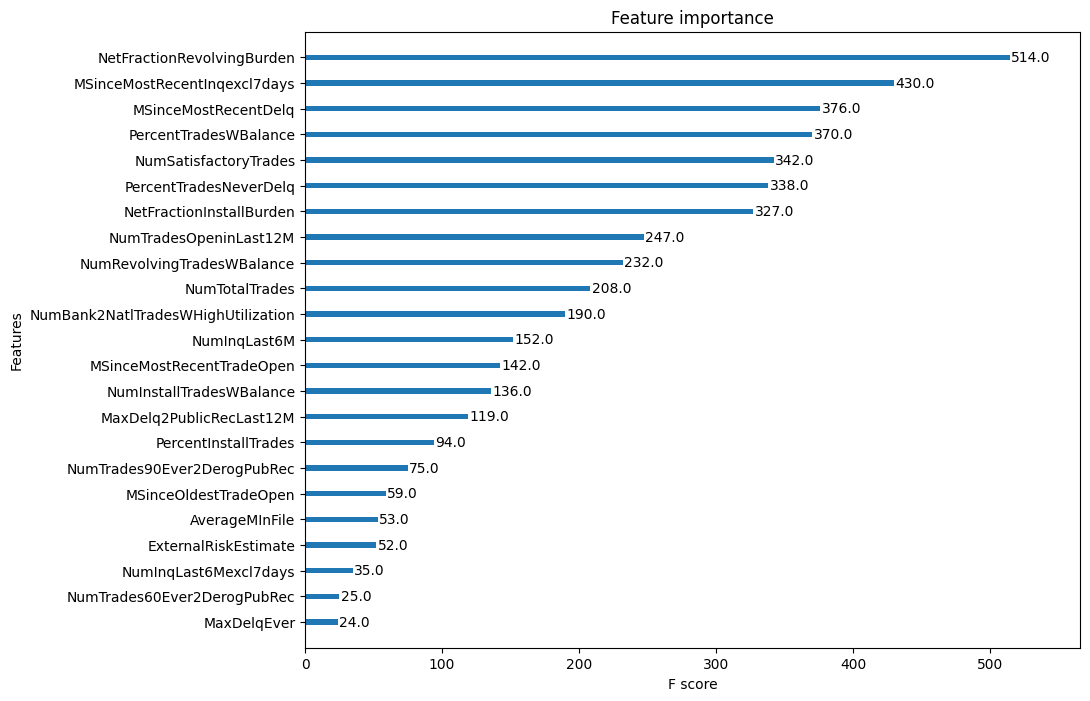

In [10]:
# XGBoost 중요도 플롯
plt.figure(figsize=(10,8))
ax = plt.gca()
xgb.plot_importance(bst, grid=False, ax=ax)
plt.show()

Input my data of each feature

In [11]:
print("순서대로 값을 입력해주세요")
data_ = []

data_.append(int(input("ExternalRiskEstimate(외부 신용점수 추정치): ")))
data_.append(int(input("MSinceOldestTradeOpen(가장 오래된 거래가 열린 이후 경과한 개월 수): ")))
data_.append(int(input("MSinceMostRecentTradeOpen(최근 거래가 열린 이후 경과한 개월 수): ")))
data_.append(int(input("AverageMInFile(신용 기록 파일 내 평균 월수): ")))
data_.append(int(input("NumSatisfactoryTrades(만족스러운 거래 수): ")))
data_.append(int(input("NumTrades60Ever2DerogPubRec(60일 이상 연체 또는 부정적 공공 기록이 있는 거래 수): ")))
data_.append(int(input("NumTrades90Ever2DerogPubRec(90일 이상 연체된 거래 수): ")))
data_.append(int(input("PercentTradesNeverDelq(연체되지 않은 거래의 비율): ")))
data_.append(int(input("MSinceMostRecentDelq(최근 연체 이후 경과한 개월 수): ")))
data_.append(int(input("MaxDelq2PublicRecLast12M(지난 12개월 동안의 공공 기록에서 가장 큰 연체 기록): ")))
data_.append(int(input("MaxDelqEver(최대 연체 기록): ")))
data_.append(int(input("NumTotalTrades(전체 거래 수): ")))
data_.append(int(input("NumTradesOpeninLast12M(최근 12개월 동안 개설된 거래 수): ")))
data_.append(int(input("PercentInstallTrades(할부 거래 비율): ")))
data_.append(int(input("MSinceMostRecentInqexcl7days(최근 7일 제외, 신용 조회 이후 경과한 개월 수): ")))
data_.append(int(input("NumInqLast6M(지난 6개월 동안 신용 조회 수): ")))
data_.append(int(input("NumInqLast6Mexcl7days(지난 6개월 동안 신용 조회 수, 최근 7일 제외): ")))
data_.append(int(input("NetFractionRevolvingBurden(순회전 부채 부담 비율): ")))
data_.append(int(input("NetFractionInstallBurden(할부 부채 부담 비율): ")))
data_.append(int(input("NumRevolvingTradesWBalance(잔액이 있는 회전 신용 거래 수): ")))
data_.append(int(input("NumInstallTradesWBalance(잔액이 있는 할부 신용 거래 수): ")))
data_.append(int(input("NumBank2NatlTradesWHighUtilization(높은 사용 비율을 보이는 거래 수): ")))
data_.append(int(input("PercentTradesWBalance(잔액이 있는 거래 비율): ")))

print(data_)


순서대로 값을 입력해주세요


ValueError: invalid literal for int() with base 10: ''

In [11]:
new_data = pd.DataFrame({
    'ExternalRiskEstimate': [data_[0]],
    'MSinceOldestTradeOpen': [data_[1]],
    'MSinceMostRecentTradeOpen': [data_[2]],
    'AverageMInFile': [data_[3]],
    'NumSatisfactoryTrades': [data_[4]],
    'NumTrades60Ever2DerogPubRec': [data_[5]],
    'NumTrades90Ever2DerogPubRec': [data_[6]],
    'PercentTradesNeverDelq': [data_[7]],
    'MSinceMostRecentDelq': [data_[8]],
    'MaxDelq2PublicRecLast12M': [data_[9]],
    'MaxDelqEver': [data_[10]],
    'NumTotalTrades': [data_[11]],
    'NumTradesOpeninLast12M': [data_[12]],
    'PercentInstallTrades': [data_[13]],
    'MSinceMostRecentInqexcl7days': [data_[14]],
    'NumInqLast6M': [data_[15]],
    'NumInqLast6Mexcl7days': [data_[16]],
    'NetFractionRevolvingBurden': [data_[17]],
    'NetFractionInstallBurden': [data_[18]],
    'NumRevolvingTradesWBalance': [data_[19]],
    'NumInstallTradesWBalance': [data_[20]],
    'NumBank2NatlTradesWHighUtilization': [data_[21]],
    'PercentTradesWBalance': [data_[22]],
})

In [ ]:
dnew = xgb.DMatrix(new_data)

y = bst.predict(dnew)
print(f"Predicted probability: {y[0]:.4%}")

prediction = ""
if y[0] > 0.5:
  prediction = "Bad"
else:
  prediction = "Good"

In [ ]:
# SHAP 분석 추가
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(new_data)

# SHAP 요약 플롯 (훈련 데이터에 대한 변수 중요도 시각화)
shap.summary_plot(shap_values, new_data)

In [ ]:
# XGBoost의 예측을 확률로 반환하도록 하는 래핑된 함수
def predict_fn_for_lime(input_data):
    dmatrix_data = xgb.DMatrix(input_data, feature_names=list(x_train.columns))
    # 확률 값으로 반환하여 LIME에서 사용 가능하게 함
    probas = bst.predict(dmatrix_data)  # 확률 값 반환
    return np.column_stack([1 - probas, probas])  # LIME은 클래스별 확률을 받으므로 [1-p, p] 형식으로 반환

# LIME 분석 추가
lime_explainer = lime.lime_tabular.LimeTabularExplainer(x_train.values,
                                                        feature_names=list(x_train.columns),
                                                        class_names=['Good', 'Bad'],
                                                        discretize_continuous=True)

# 테스트 데이터에서 예측한 첫 번째 샘플에 대해 LIME 해석 수행
i = 0  # 분석할 데이터 포인트의 인덱스
lime_exp = lime_explainer.explain_instance(new_data.iloc[i].values, predict_fn_for_lime, num_features=10)
lime_exp.show_in_notebook()


In [ ]:
# LIME 중요도 출력
lime_importance = pd.DataFrame(lime_exp.as_list(), columns=['Feature', 'LIME Importance'])
print("\n--- LIME 중요도 ---")
print(lime_importance)

# SHAP 해석 (테스트 데이터 첫 번째 샘플)
shap_values_test = explainer.shap_values(new_data.iloc[0:1])
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values_test[0], new_data.iloc[0:1])

# SHAP 중요도 출력
shap_importance = pd.DataFrame({'Feature': new_data.columns, 'SHAP Importance': np.abs(shap_values_test[0])})
shap_importance = shap_importance.sort_values(by='SHAP Importance', ascending=False).head(10)
print("\n--- SHAP 중요도 ---")
print(shap_importance)

Make input for gemma

In [16]:
gemma_input = "Question:\nWe have performed binary classification using the HELOC (Home Equity Line of Credit) Dataset and XGBClassifier to predict whether a customer will be 'Good' or 'Bad' in terms of credit risk. A 'Bad' classification means the customer was 90 days or more past due at least once within 24 months of opening their credit account, while a 'Good' classification means they never exceeded 90 days overdue during this period.\n"
predict_input = "The model has predicted that this customer falls into the " + prediction + "category, with the following prediction probability:\n" + "- Good:" + str(1 - y[0]) + "\n" + "- Bad:" + str(y[0]) + "\n"


predict_input += "In order to better understand this prediction, please explain the contributions of individual features based on two different explainability methods: SHAP and LIME. Follow the steps below to provide a thorough, yet easy-to-understand explanation.\n"
predict_input += """\n### Steps:\n1. **SHAP Analysis**: Explain the SHAP values for each key feature. For each feature, describe how it influenced the model’s prediction (either positively or negatively) and by how much.\n2. **LIME Analysis**: Provide an analysis of the LIME results. Explain how each feature influenced the prediction according to LIME, focusing on the thresholds and how they shaped the prediction.\n3. **Comparison and Synthesis**: Compare the insights from SHAP and LIME analyses. Discuss any similarities or differences between the two methods, and provide a synthesized explanation of how these key features collectively influenced the final prediction.\n4. **Final Explanation for Non-Experts**: Summarize the key insights from the analyses in plain language. Avoid technical jargon, and focus on making the explanation simple and clear for someone without a background in machine learning or finance.\n\n### Context:\n**Prediction Details:**\n"""
predict_input += """- Predicted to """ + prediction

In [17]:
lime_vals = lime_exp.as_list()
lime_input = "**LIME Analysis (Feature, LIME Importance):**\n"
for data, vals in lime_vals:
  lime_input += "- " + str(data) + ": " + str(vals) + "\n"

In [18]:
shap_input = "**SHAP Analysis (Feature, SHAP Importance):**\n"
feature_list = shap_importance['Feature'].tolist()
importance_list = shap_importance['SHAP Importance'].tolist()


for i in range(len(feature_list)):
  shap_input += "- " + str(feature_list[i]) + ": " + str(importance_list[i]) + "\n"

In [19]:
last_input = """Answer:\n1. **SHAP Analysis**: Break down each feature's SHAP importance, and explain how the model used these features to influence the final prediction.\n2. **LIME Analysis**: Provide a detailed explanation of LIME feature importance, discussing how thresholds and feature values contributed to the model’s decision.\n3. **Comparison**: Highlight the similarities and differences between SHAP and LIME, focusing on how they each interpret the importance of features differently.\n4. **Non-Technical Summary**: Explain the prediction in a way that is easy for a non-expert to understand, avoiding technical terms where possible.\n"""

In [ ]:
gemma_input += predict_input + "\n" + shap_input + "\n" + lime_input + "\n" + last_input

print(gemma_input)

Load Gemma

In [ ]:
from huggingface_hub import login
import inspect

token = input("Enter your Huggingface token for Gemma2 9b:")
login(token)

In [ ]:
!pip install -U bitsandbytes

In [ ]:
# pip install accelerate
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import torch

quantization_config = BitsAndBytesConfig(load_in_8bit=True)

tokenizer = AutoTokenizer.from_pretrained("google/gemma-2-9b-it")
model = AutoModelForCausalLM.from_pretrained(
    "google/gemma-2-9b-it",
    #device_map="auto",
    #torch_dtype=torch.bfloat16,
    quantization_config=quantization_config,
)
device = torch.device("cuda:0")

In [33]:
def generate_response(prompt):
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    output = model.generate(inputs["input_ids"], max_length=10000, num_return_sequences=1)
    response = tokenizer.decode(output[0], skip_special_tokens=True)
    return response

In [34]:
gemma_response = generate_response(gemma_input)

In [ ]:
print(f"Gemma: {gemma_response}")